# Introduction

- TODO: Write introduction
- TODO: Flesh out sections with text

# Methods

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import h5py
from IPython.display import display, Math

from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm, norm, truncnorm, rv_continuous

import astropy.constants as const
import astropy.units as u
import astropy.uncertainty as unc
from astropy.cosmology import WMAP9, z_at_value
from astropy.modeling.functional_models import Linear1D, Const1D, Shift, Gaussian1D
from astropy.modeling.tabular import Tabular1D

from tqdm.autonotebook import tqdm

from src.models.agn_proxy import (Hopkins2007QuasarFormationDensity,
                                  LogNormal1D, Const3D, QuasarProxyBinaries, Hopkins2007QuasarFormationDensity,
                                  ModifiedSchechter, Marconi2004BHMF, Hopkins2007QuasarNumberDensity,
                                  Goulding2019J1010Binaries)
from src.models.major_merger import (Schechter1D, Schechter2D,
                                     DoubleSchechter2D, TripleSchechter2D,
                                     PairFraction3D, PairFraction3D_3bins,
                                     Timescale3D, Sesana2013_Schechter,
                                     Sesana2013_DoubleSchechter,
                                     Sesana2013_TripleSchechter)

<ipython-input-1-659d6722bacf>:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Global variables
n_samples = int(2 ** 10)
n_mesh = int(2 ** 5)
n_samples, n_mesh

(1024, 32)

In [3]:
# class declarations
class split_normal(rv_continuous):
    def __init__(self, loc, scale1, scale2, *args, **kwargs):
        self.loc = loc
        self.scale1 = scale1
        self.scale2 = scale2
        self.normalization = 2 / (scale1 + scale2)
        super().__init__(self, *args, **kwargs)
        
    def _pdf(self, x):
        if x < self.loc:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale2)
    
    def _cdf(self, x):
        if x < self.loc:
            return self.normalization * self.scale1 * truncnorm.cdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return 1 - self.normalization * self.scale2 * (1 - truncnorm.cdf(x, self.a, self.b, self.loc, self.scale2))
    
    def _ppf(self, q):
        p = self.scale1 / (self.scale1 + self.scale2)
        
        output = np.where(q <= p,
                          self.loc + self.scale1
                          * truncnorm.ppf(.5 * (self.scale1 + self.scale2) * q
                                          / self.scale1, self.a, self.b),
                          self.loc + self.scale2
                          * truncnorm.ppf(0.5 * ((self.scale1 + self.scale2)
                                                 * (1 + q) - 2 * self.scale1)
                                          / self.scale2, self.a, self.b))
        return np.squeeze(output)

In [4]:
def trunc_norm_dist(a=0, b=np.inf, loc=0, scale=1, size=n_samples):
    return truncnorm.rvs(a=(a - loc) / scale, b=(b - loc) / scale,
                                          loc=loc, scale=scale,
                                          size=size)

## Dependencies/Assumptions

### Shared

#### Parameter space

In [5]:
log_m_bh_min = 7
log_m_bh_max = 10

log_m_bh_range = np.linspace(log_m_bh_min, log_m_bh_max, num=n_mesh)

z_min = 0
z_max = 3
z_range = np.linspace(z_min, z_max, num=n_mesh)

q_min = 0.25
q_max = 1
q_range = np.linspace(q_min, q_max, num=n_mesh)

#### Fiducial values

In [6]:
fidhz = (1 / u.yr).to(u.Hz)

In [7]:
# Calculate the standard deviation from the quoted NANOGrav 5-95% interval
NANOGrav_strain95 = 2.67e-15
NANOGrav_strain05 = 1.37e-15

NANOGrav_log_std = (np.log10(NANOGrav_strain95) - np.log10(NANOGrav_strain05)) / (norm.ppf(.95) - norm.ppf(.05))

In [8]:
# NANOGrav 12.5-yr
NANOGrav_log_strain = unc.normal(np.log10(1.92e-15), std=NANOGrav_log_std, n_samples=n_samples).distribution

In [9]:
quantiles = 10 ** np.quantile(NANOGrav_log_strain, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'h_{{c, \rm{{NG12.5}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Cappellari (2013)

##### $M_{\rm{gal}} - M_{K}$ model parameters

In [10]:
a_cappellari = unc.normal(10.5829, std=0.0086, n_samples=n_samples).distribution
b_cappellari = unc.normal(-0.4449, std=0.0091, n_samples=n_samples).distribution

##### $M_{\rm{gal}} - K$ model

In [11]:
c_intercept = a_cappellari + (b_cappellari * 23)
c_slope = b_cappellari
cappellari_mgal_k = Linear1D(slope=c_slope,
                             intercept=c_intercept,
                             n_models=n_samples)

In [12]:
print(cappellari_mgal_k)
with open('../models/Cappellari2013_mgal_mk_relation.pkl', 'wb') as f:
    pickle.dump(cappellari_mgal_k, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
           slope              intercept      
    -------------------- --------------------
     -0.4438561756272007   0.3809565864000639
     -0.4649539467934927 -0.08610949956817926
     -0.4369638576522459   0.5463475705103775
     -0.4583986301102283 0.049583720299015255
    -0.42828356756054353   0.7360158255049338
     -0.4557189739119574  0.10612320419297205
    -0.44024950663710155  0.45263450498288726
     -0.4413316397726885  0.43126892851594256
    -0.44512588858378854   0.3488354317199249
     -0.4419386174992542  0.40107267065658014
                     ...                  ...
    -0.44640105462564883  0.30317074115625076
     -0.4493739241641746  0.25671691430629373
      -0.436872466989629    0.534292175262328
      -0.445255678766464  0.33605916358189347
     -0.4519919927013643  0.19860523800630148
    -0.44417636009179556   0.3793203799239695
    -0.45757515664212745  0.06699297472008325


#### McConnell & Ma (2013)

##### $M - M_{\rm{bulge}}$ model parameters

In [13]:
alpha_mcconnell_ma = unc.normal(8.46, std=.08, n_samples=n_samples).distribution
beta_mcconnell_ma = unc.normal(1.05, std=.11, n_samples=n_samples).distribution
intrinsic_disp_mcconnell_ma = np.random.normal(scale=.34, size=n_samples)

##### $M - M_{\rm{bulge}}$ model

Scaled to $M_{\rm{bulge}} / 10^{11}\;\rm{M}_{\odot}$

In [14]:
mm_intercept = alpha_mcconnell_ma - (beta_mcconnell_ma * 11)
mm_slope = beta_mcconnell_ma
mcconnell_ma_m_mbulge = Linear1D(slope=mm_slope,
                                 intercept=mm_intercept,
                                 n_models=n_samples)

In [15]:
print(mcconnell_ma_m_mbulge)
with open('../models/McConnellMa2013_mbh_mbulge_relation.pkl', 'wb') as f:
    pickle.dump(mcconnell_ma_m_mbulge, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          slope             intercept     
    ------------------ -------------------
    0.9685751159553384 -2.2203743659291817
    0.9735212690689921   -2.22507939753827
    0.9088036384240498 -1.7125609025848796
    1.2113356157407091  -4.998781900835956
    1.2393773703877262  -5.213229788973996
    1.1468892287189014  -4.130728244845489
    1.0690262100128782 -3.2425292748677865
    0.9887066911826031 -2.3690582971747585
    0.9865887125395272 -2.5096777486876434
    1.0426337906530274  -3.109268526242783
                   ...                 ...
    1.1575860366382704  -4.246646940014832
    0.9994949968596814  -2.587208101597046
    1.1043497219981406  -3.725694302836599
     1.262832704073706  -5.523024294195524
    1.1171114751589903  -3.835715451238535
    0.7181876518261151  0.6688234123647687
    1.0862356774225987 -3.5681171861894327
     1.093600980157593 -3.5776067558400015
    0.98878734219

#### Mingarelli+ (2017)

#### $M_{\rm{BH}} - M_{\rm{K}}$

In [16]:
log_m_bh_m_k = cappellari_mgal_k | mcconnell_ma_m_mbulge

##### Mass ratio range

In [17]:
q_min_mingarelli = .25
q_max_mingarelli = 1

##### Mass ranges

In [18]:
galaxies = pd.read_csv('../data/external/25/added_mks.lst', delimiter='\s+',
                       usecols=[0, 1, 2, 3, 4], index_col=False)
galaxies = galaxies.append(pd.read_csv('../data/external/25/schutzMa_extension.txt',
                                       delimiter='\s+',
                                       usecols=[0, 1, 2, 3, 4],
                                       index_col=False))
catalog = pd.read_csv('../data/external/25/2mass_galaxies.lst', delimiter='\s+',
                      usecols=[1, 2, 3, 4, 5], index_col=False,
                      names=['RA', 'DEC', 'D_L(Mpc)', 'Kmag', 'Name'])
catalog

,RA,DEC,D_L(Mpc),Kmag,Name
0,189.998,-11.623,14.63,-25.88,NGC4594
1,187.445,8.000,20.78,-26.20,NGC4472
2,50.674,-37.208,19.76,-25.90,NGC1316
3,190.917,11.553,20.78,-25.86,NGC4649
4,187.706,12.391,20.78,-25.78,NGC4486
...,...,...,...,...,...
5105,214.458,0.511,223.09,-25.11,PGC051063
5106,64.351,-37.282,216.26,-25.05,PGC014806
5107,123.188,11.632,223.76,-25.13,PGC1396460
5108,206.159,21.093,218.77,-25.30,PGC3089894


In [19]:
log_m_bhb_mingarelli = np.array([log_m_bh_m_k(Mk) for Mk in catalog['Kmag']])
log_m_bhb_mingarelli = np.random.normal(log_m_bhb_mingarelli, .34)
log_m_bhb_mingarelli_q = np.quantile(log_m_bhb_mingarelli, q=[.16, .5, .84], axis=1)
log_m_bhb_mingarelli_max = np.max(log_m_bhb_mingarelli_q)
log_m_bhb_mingarelli_min = np.min(log_m_bhb_mingarelli_q)
display(Math(r'\log M_{{\rm{{BHB, min, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_min)))
display(Math(r'\log M_{{\rm{{BHB, max, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
log_m_bh_min_mingarelli = log_m_bhb_mingarelli_min - np.log10(1 + q_min_mingarelli)
log_m_bh_max_mingarelli = log_m_bhb_mingarelli_max - np.log10(1 + q_max_mingarelli)
log_m_bh_max = log_m_bh_max_mingarelli
display(Math(r'\log M_{{\rm{{BH, min, M17}}}} = {0:.2f}'
             .format(log_m_bh_min_mingarelli)))
display(Math(r'\log M_{{\rm{{BH, max, M17}}}} = {0:.2f}'
             .format(log_m_bh_max_mingarelli)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### AGN-based model

#### $q$ distribution

In [21]:
var_log_q = np.repeat(.5, n_samples)
mode_log_q = np.repeat(0, n_samples)
median_log_q = mode_log_q + (var_log_q ** 2)

In [22]:
q_distrib = LogNormal1D(mu=median_log_q, std=var_log_q, n_models=n_samples)

In [23]:
print(q_distrib)
with open('../models/q_distrib.pkl', 'wb') as f:
    pickle.dump(q_distrib, f)

Model: LogNormal1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
     mu  std
    ---- ---
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
     ... ...
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    Length = 1024 rows


#### Hopkins+ (2007)

##### Differential quasar formation density model parameters

In [24]:
log_formation_rate_normalization = unc.normal(-3.830, std=0.031, n_samples=n_samples).distribution
log_formation_rate_power_law_slope = unc.normal(-4.02, std=0.36, n_samples=n_samples).distribution
log_mass_break_normalization = unc.normal(8.959, std=0.032, n_samples=n_samples).distribution
log_mass_break_k_1 = unc.normal(1.18, std=0.13, n_samples=n_samples).distribution
log_mass_break_k_2 = unc.normal(-6.68, std=0.44, n_samples=n_samples).distribution
low_mass_slope = np.repeat(.2, n_samples)
high_mass_slope_normalization = unc.normal(2.86, std=0.16, n_samples=n_samples).distribution
high_mass_slope_k_1 = unc.normal(1.80, std=0.18, n_samples=n_samples).distribution
high_mass_slope_k_2 = unc.normal(-1.13, std=0.09, n_samples=n_samples).distribution
z_ref = np.repeat(2, n_samples)

##### Differential quasar formation density model

In [25]:
quasar_formation_rate = Hopkins2007QuasarFormationDensity(log_formation_rate_normalization=log_formation_rate_normalization,
                                                          log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                          log_mass_break_normalization=log_mass_break_normalization,
                                                          log_mass_break_k_1=log_mass_break_k_1,
                                                          log_mass_break_k_2=log_mass_break_k_2,
                                                          low_mass_slope=low_mass_slope,
                                                          high_mass_slope_normalization=high_mass_slope_normalization,
                                                          high_mass_slope_k_1=high_mass_slope_k_1,
                                                          high_mass_slope_k_2=high_mass_slope_k_2,
                                                          z_ref=z_ref,
                                                          n_models=n_samples)

In [26]:
print(quasar_formation_rate)
with open('../models/Hopkins2007_quasar_formation_rate_binaries.pkl', 'wb') as f:
    pickle.dump(quasar_formation_rate, f)

Model: Hopkins2007QuasarFormationDensity
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    log_formation_rate_normalization log_formation_rate_power_law_slope ... z_ref
    -------------------------------- ---------------------------------- ... -----
                 -3.8244313328186146                -4.4525766379311476 ...   2.0
                  -3.858641952674652                 -4.065376367212256 ...   2.0
                 -3.8768736375783766                -4.0539896246914555 ...   2.0
                   -3.83555880984937                -3.7600161565399697 ...   2.0
                 -3.8605211106478325                 -4.263984978177939 ...   2.0
                 -3.8184877910467883                 -4.076424505493263 ...   2.0
                 -3.8273561970502716                 -4.228505946618061 ...   2.0
                  -3.832116477226825                  -3.54925259215549 ...   2.0
                 -3.8899693717556767                 -4.246613725946603

### Goulding+ (2019) AGN-based model

#### Goulding+ (2019) bounds

##### J1010-like quasar parameters

In [27]:
# Number density luminosity bounds
log_l_min = np.log10((.3 * (10 ** 46.) * u.erg / u.s).to(u.Lsun).value)
log_l_max = np.log10((.3 * (10 ** 47.) * u.erg / u.s).to(u.Lsun).value)
log_l_min_goulding = np.repeat(log_l_min, n_samples)
log_l_max_goulding = np.repeat(log_l_max, n_samples)

log_m_min_goulding = 8
log_m_max_goulding = 10

log_m_chirp_min_goulding = log_m_min_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))
log_m_chirp_max_goulding = log_m_max_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))

log_m_bh_min_goulding = log_m_min_goulding - np.log10(1 + q_max)
log_m_bh_max_goulding = log_m_max_goulding - np.log10(1 + q_max)

In [28]:
log_l_min, log_l_max

(11.894149325614856, 12.894149325614856)

#### Sheth+ (2003)

##### Velocity dispersion function parameters

In [29]:
dispersion_normalization_sheth = unc.normal(0.002, std=.0001, n_samples=n_samples).distribution * (WMAP9.h ** 3)
dispersion_break_sheth = np.repeat(88.8, n_samples)  # unc.normal(88.8, std=17.7, n_samples=n_samples).distribution
alpha_sheth = np.repeat(6.5, n_samples)  # unc.normal(6.5, std=1., n_samples=n_samples).distribution
beta_sheth = np.repeat(1.93, n_samples)

##### Velocity dispersion function

In [30]:
sheth_2003_velocity_dispersion_function = ModifiedSchechter(normalization=dispersion_normalization_sheth,
                                                            sigma_break=dispersion_break_sheth,
                                                            alpha=alpha_sheth,
                                                            beta=beta_sheth,
                                                            n_models=n_samples)

In [31]:
print(sheth_2003_velocity_dispersion_function)
with open('../models/Sheth2003_velocity_dispersion_function.pkl', 'wb') as f:
    pickle.dump(sheth_2003_velocity_dispersion_function, f)

Model: ModifiedSchechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        normalization     sigma_break alpha beta
    --------------------- ----------- ----- ----
     0.000645851771586713        88.8   6.5 1.93
    0.0007156710047186872        88.8   6.5 1.93
    0.0006977354039603724        88.8   6.5 1.93
    0.0006353428470020372        88.8   6.5 1.93
    0.0006250898219326213        88.8   6.5 1.93
    0.0006734062061054915        88.8   6.5 1.93
    0.0006636717259728903        88.8   6.5 1.93
    0.0006953284005754947        88.8   6.5 1.93
    0.0006854568609716077        88.8   6.5 1.93
    0.0006659860107777035        88.8   6.5 1.93
                      ...         ...   ...  ...
    0.0007358789890159909        88.8   6.5 1.93
    0.0007161426620671286        88.8   6.5 1.93
     0.000700720493124833        88.8   6.5 1.93
    0.0006814850513604481        88.8   6.5 1.93
    0.0006074849129182158        88.8   6.5 1.93
    0.0006231883502291318    

#### Marconi+ (2004)

##### Black hole mass function parameters

In [32]:
b_marconi = unc.normal(4.11, std=.33, n_samples=n_samples).distribution
a_marconi = unc.normal(8.30, std=.07, n_samples=n_samples).distribution - 2.3 * b_marconi
intrinsic_disp_marconi = np.repeat(.3, n_samples)

##### Black hole mass function

In [33]:
marconi_2004_black_hole_mass_function = Marconi2004BHMF(mass_dispersion_intercept=a_marconi,
                                                        mass_dispersion_slope=b_marconi,
                                                        intrinsic_scatter=intrinsic_disp_marconi,
                                                        dispersion_norm=dispersion_normalization_sheth,
                                                        log_dispersion_break=np.log10(dispersion_break_sheth),
                                                        dispersion_alpha=alpha_sheth,
                                                        dispersion_beta=beta_sheth,
                                                        n_models=n_samples)

In [34]:
print(marconi_2004_black_hole_mass_function)
with open('../models/Marconi2004_black_hole_mass_function.pkl', 'wb') as f:
    pickle.dump(marconi_2004_black_hole_mass_function, f)

Model: Marconi2004BHMF
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
    mass_dispersion_intercept mass_dispersion_slope ... dispersion_beta
    ------------------------- --------------------- ... ---------------
           -1.477813842603945     4.233563197065207 ...            1.93
          0.35935339769029095    3.4576977050788607 ...            1.93
         -0.46306772165348065     3.810152244277128 ...            1.93
          -1.0814267405930114     4.044764317275804 ...            1.93
          -1.6653836224896459     4.357884012655176 ...            1.93
          -1.3307613649430916    4.1390059074555365 ...            1.93
            -1.64215807966373     4.353640373397945 ...            1.93
          -1.4575691854308506     4.220369405881091 ...            1.93
          -0.9462401714376618     3.997430925772392 ...            1.93
          -1.9091538452065695    4.3923039857187565 ...            1.93
                          ...                   .

#### Hopkins+ (2007)

##### Quasar luminosity function number density parameters

In [35]:
log_norm_hopkins = unc.normal(-4.825, std=0.060, n_samples=n_samples).distribution
log_break_luminosity_norm_hopkins = unc.normal(13.036, std=0.043, n_samples=n_samples).distribution
log_break_luminosity_k1_hopkins = unc.normal(0.632, std=0.077, n_samples=n_samples).distribution
log_break_luminosity_k2_hopkins = unc.normal(-11.76, std=0.38, n_samples=n_samples).distribution
log_break_luminosity_k3_hopkins = unc.normal(-14.25, std=0.80, n_samples=n_samples).distribution
faint_end_slope_norm_hopkins = unc.normal(0.417, std=0.055, n_samples=n_samples).distribution
faint_end_slope_k_hopkins = unc.normal(-0.623, std=0.132, n_samples=n_samples).distribution
bright_end_slope_norm_hopkins = unc.normal(2.174, std=0.055, n_samples=n_samples).distribution
bright_end_slope_k1_hopkins = unc.normal(1.460, std=0.096, n_samples=n_samples).distribution
bright_end_slope_k2_hopkins = unc.normal(-0.793, std=0.057, n_samples=n_samples).distribution
z_ref_hopkins = np.repeat(2, n_samples)

##### Quasar luminosity function number density

In [36]:
hopkins_2007_quasar_number_density = Hopkins2007QuasarNumberDensity(log_l_min=log_l_min_goulding,
                                                                    log_l_max=log_l_max_goulding,
                                                                    log_norm=log_norm_hopkins,
                                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                                    z_ref=z_ref_hopkins,
                                                                    n_models=n_samples)

In [37]:
print(hopkins_2007_quasar_number_density)
with open('../models/Hopkins2007_quasar_number_density.pkl', 'wb') as f:
    pickle.dump(hopkins_2007_quasar_number_density, f)

Model: Hopkins2007QuasarNumberDensity
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        log_l_min          log_l_max      ... bright_end_slope_k2 z_ref
    ------------------ ------------------ ... ------------------- -----
    11.894149325614856 12.894149325614856 ... -0.7644517254165534   2.0
    11.894149325614856 12.894149325614856 ... -0.8203370583698569   2.0
    11.894149325614856 12.894149325614856 ... -0.7269407250353789   2.0
    11.894149325614856 12.894149325614856 ... -0.8207259550762361   2.0
    11.894149325614856 12.894149325614856 ... -0.7027041519069736   2.0
    11.894149325614856 12.894149325614856 ... -0.7953102035172851   2.0
    11.894149325614856 12.894149325614856 ... -0.8774447231622162   2.0
    11.894149325614856 12.894149325614856 ... -0.8234580404211997   2.0
    11.894149325614856 12.894149325614856 ... -0.8051706780738991   2.0
    11.894149325614856 12.894149325614856 ... -0.7316191641062401   2.0
                   ...            

#### Goulding+ (2019) dual AGN model

##### J1010-like quasar number density

In [38]:
j1010_quasars = Goulding2019J1010Binaries(binary_normalization=np.repeat(1, n_samples),
                                          mass_dispersion_intercept=a_marconi,
                                          mass_dispersion_slope=b_marconi,
                                          intrinsic_scatter=intrinsic_disp_marconi,
                                          dispersion_norm=dispersion_normalization_sheth,
                                          log_dispersion_break=np.log10(dispersion_break_sheth),
                                          dispersion_alpha=alpha_sheth,
                                          dispersion_beta=beta_sheth,
                                          log_l_min=log_l_min_goulding,
                                          log_l_max=log_l_max_goulding,
                                          log_dens_norm=log_norm_hopkins,
                                          log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                          log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                          log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                          log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                          faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                          faint_end_slope_k=faint_end_slope_k_hopkins,
                                          bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                          bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                          bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                          z_ref=z_ref_hopkins,
                                          n_models=n_samples)

### Merger models

#### Bell+ (2003)

##### Galactic mass function parameters

In [39]:
z_bell = 0.
phi_bell = trunc_norm_dist(a=0, b=np.inf, loc=0.0133, scale=0.0006, size=n_samples) * (WMAP9.h ** 3)
log_mgal_break_bell = unc.normal(10.63, std=.01, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
alpha_bell = unc.normal(-0.86, std=.04, n_samples=n_samples).distribution

##### Galactic mass function

In [40]:
bell_2003_galactic_mass_function = Schechter1D(normalization=phi_bell,
                                               log_m_break=log_mgal_break_bell,
                                               exponent=alpha_bell,
                                               n_models=n_samples)

In [41]:
print(bell_2003_galactic_mass_function)
with open('../models/Bell2003_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(bell_2003_galactic_mass_function, f)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        normalization        log_m_break           exponent     
    --------------------- ------------------ -------------------
     0.004402848079292425 10.964259410717911 -0.8966528825359871
     0.004799570864228793 10.952014373439996 -0.9311785341951614
     0.004795307230749849 10.923049171710707   -0.89462497224772
    0.0042854524863657215 10.961022874071766 -0.9081593180727424
     0.004207433208741216  10.94247109215398 -0.9100655089176691
     0.004278329445001347 10.939974633133161 -0.7685868735590129
     0.004633544476641203 10.938362579135982 -0.8536197135102147
      0.00442534897028958 10.935431887475312 -0.8135145025294357
    0.0042789096278489005 10.938008844348477 -0.8677208382572665
     0.004213200978980367 10.944341507687467 -0.7991525368733766
                      ...                ...                 ...
     0.004417206645124821 10.930533184608214 -0.8862292000991594
     0.

#### Borch+ (2006)

##### Galactic mass function parameters

In [42]:
z_borch = np.array([0, .3, .5, .7, .9])
z_range_borch = np.linspace(0, .9, num=n_mesh)

norm_0_borch = trunc_norm_dist(a=0, b=np.inf, loc=37e-4, scale=4e-4, size=n_samples)
norm_3_borch = trunc_norm_dist(a=0, b=np.inf, loc=17e-4, scale=7e-4, size=n_samples)
norm_5_borch = trunc_norm_dist(a=0, b=np.inf, loc=15e-4, scale=5e-4, size=n_samples)
norm_7_borch = trunc_norm_dist(a=0, b=np.inf, loc=11e-4, scale=4e-4, size=n_samples)
norm_9_borch = trunc_norm_dist(a=0, b=np.inf, loc=9e-4, scale=3e-4, size=n_samples)

log_m_gal_0_borch = unc.normal(10.81, std=.1, n_samples=n_samples).distribution
log_m_gal_3_borch =  unc.normal(10.97, std=.09, n_samples=n_samples).distribution
log_m_gal_5_borch =  unc.normal(10.95, std=.1, n_samples=n_samples).distribution
log_m_gal_7_borch =  unc.normal(11.06, std=.18, n_samples=n_samples).distribution
log_m_gal_9_borch =  unc.normal(11.01, std=.08, n_samples=n_samples).distribution

alpha_0_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_3_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_5_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_7_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_9_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution

##### Galactic mass function

In [43]:
borch_2006_galactic_mass_function = Schechter2D(norm1=norm_0_borch,
                                                norm2=norm_3_borch,
                                                norm3=norm_5_borch,
                                                norm4=norm_7_borch,
                                                norm5=norm_9_borch,
                                                log_m_break1=log_m_gal_0_borch,
                                                log_m_break2=log_m_gal_3_borch,
                                                log_m_break3=log_m_gal_5_borch,
                                                log_m_break4=log_m_gal_7_borch,
                                                log_m_break5=log_m_gal_9_borch,
                                                exp1=alpha_0_borch,
                                                exp2=alpha_3_borch,
                                                exp3=alpha_5_borch,
                                                exp4=alpha_7_borch,
                                                exp5=alpha_9_borch,
                                                n_models=n_samples)

In [44]:
print(borch_2006_galactic_mass_function)
with open('../models/Borch2006_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(borch_2006_galactic_mass_function, f)

Model: Schechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm1                 norm2         ...         exp5       
    --------------------- --------------------- ... -------------------
     0.003617836199216489 0.0016007676982795842 ... -0.7512220089192201
     0.004131434517302557  0.001981508836089249 ... -0.6855307116772584
    0.0036825232107644957 0.0026911280735320664 ... -0.7374606985334795
    0.0033905662851477928  0.002785097224222197 ... -0.7378564277879998
    0.0035146265043028537 0.0012507404452254494 ... -0.6683082144493488
     0.004104862577731836 0.0002864038192127631 ... -0.7815799586704917
    0.0041094515529697066 0.0012189387998480087 ... -0.5399618766142544
     0.003644055783899122 0.0019571633983839543 ... -0.7219387245843664
     0.004806440907498277 0.0011380885815944204 ... -0.6207576156454273
     0.003522936134759448 0.0026785068946006867 ... -0.7964726138365872
                      ...                   ... .

#### Drory+ (2009)

##### Galactic mass function parameters

In [45]:
z_drory = np.array([0, .3, .5, .7, .9])
z_range_drory = np.linspace(0, .9, num=n_mesh)

norm_0_drory_b = phi_bell
norm_3_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_5_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=1.74, scale=.09, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_7_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.16, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_9_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.94, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)

log_m_gal_0_drory_b = log_mgal_break_bell
log_m_gal_3_drory_b = unc.normal(10.90, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_5_drory_b = unc.normal(10.91, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_7_drory_b = unc.normal(10.95, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_9_drory_b = unc.normal(10.92, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)

alpha_0_drory_b = alpha_bell
alpha_3_drory_b = unc.normal(-1.06, std=.03, n_samples=n_samples).distribution
alpha_5_drory_b = unc.normal(-1.05, std=.02, n_samples=n_samples).distribution
alpha_7_drory_b = unc.normal(-.93, std=.04, n_samples=n_samples).distribution
alpha_9_drory_b = unc.normal(-.91, std=.03, n_samples=n_samples).distribution

norm_0_drory_f = np.zeros(n_samples)
norm_3_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.80, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_5_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_7_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.26, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_9_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.12, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)

log_m_gal_0_drory_f = np.zeros(n_samples) - 2. * np.log10(WMAP9.h)
log_m_gal_3_drory_f = unc.normal(9.63, std=.09, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_5_drory_f = unc.normal(9.70, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_7_drory_f = unc.normal(9.75, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_9_drory_f = unc.normal(9.85, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)

alpha_0_drory_f = np.zeros(n_samples)
alpha_3_drory_f = unc.normal(-1.73, std=.09, n_samples=n_samples).distribution
alpha_5_drory_f = unc.normal(-1.76, std=.16, n_samples=n_samples).distribution
alpha_7_drory_f = unc.normal(-1.65, std=.08, n_samples=n_samples).distribution
alpha_9_drory_f = unc.normal(-1.65, std=.24, n_samples=n_samples).distribution

##### Galactic mass function

In [46]:
drory_2009_galactic_mass_function = DoubleSchechter2D(norm11=norm_0_drory_b,
                                                      norm12=norm_3_drory_b,
                                                      norm13=norm_5_drory_b,
                                                      norm14=norm_7_drory_b,
                                                      norm15=norm_9_drory_b,
                                                      norm21=norm_0_drory_f,
                                                      norm22=norm_3_drory_f,
                                                      norm23=norm_5_drory_f,
                                                      norm24=norm_7_drory_f,
                                                      norm25=norm_9_drory_f,
                                                      log_m_break11=log_m_gal_0_drory_b,
                                                      log_m_break12=log_m_gal_3_drory_b,
                                                      log_m_break13=log_m_gal_5_drory_b,
                                                      log_m_break14=log_m_gal_7_drory_b,
                                                      log_m_break15=log_m_gal_9_drory_b,
                                                      log_m_break21=log_m_gal_0_drory_f,
                                                      log_m_break22=log_m_gal_3_drory_f,
                                                      log_m_break23=log_m_gal_5_drory_f,
                                                      log_m_break24=log_m_gal_7_drory_f,
                                                      log_m_break25=log_m_gal_9_drory_f,
                                                      exp11=alpha_0_drory_b,
                                                      exp12=alpha_3_drory_b,
                                                      exp13=alpha_5_drory_b,
                                                      exp14=alpha_7_drory_b,
                                                      exp15=alpha_9_drory_b,
                                                      exp21=alpha_0_drory_f,
                                                      exp22=alpha_3_drory_f,
                                                      exp23=alpha_5_drory_f,
                                                      exp24=alpha_7_drory_f,
                                                      exp25=alpha_9_drory_f,
                                                      n_models=n_samples)

In [47]:
print(drory_2009_galactic_mass_function)
with open('../models/Drory2009_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(drory_2009_galactic_mass_function, f)

Model: DoubleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm11                norm12        ...        exp25       
    --------------------- --------------------- ... -------------------
     0.004402848079292425 0.0009081790240627044 ... -1.3266248174021873
     0.004799570864228793 0.0008999501850589235 ... -1.8305848303223726
     0.004795307230749849 0.0009325434098896983 ...  -1.654602902896141
    0.0042854524863657215 0.0009938548180644185 ... -1.8130842197343306
     0.004207433208741216   0.00096986445051369 ... -1.5938432142775458
     0.004278329445001347 0.0009761252558431409 ... -1.8150389931361828
     0.004633544476641203 0.0010308475292850673 ... -1.9127448534803007
      0.00442534897028958 0.0009197300305065579 ... -1.9813287467720326
    0.0042789096278489005 0.0010634175006736903 ... -1.2916272528133814
     0.004213200978980367 0.0011112532024668538 ... -1.5052521150923375
                      ...                  

#### Ilbert+ (2010)

##### Galactic mass function parameters

In [48]:
z_ilbert = np.array([0, .3, .5, .7, .9, 1.1, 1.35, 1.75])
z_range_ilbert = np.linspace(0, 1.75, num=n_mesh)

norm_0_ilbert_q = phi_bell
norm_3_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.12, scale=.07, size=n_samples) * 1e-3
norm_5_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.87, scale=.04, size=n_samples) * 1e-3
norm_7_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.15, scale=.03, size=n_samples) * 1e-3
norm_9_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.03, size=n_samples) * 1e-3
norm_11_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.55, scale=.02, size=n_samples) * 1e-3
norm_135_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.26, scale=.02, size=n_samples) * 1e-3
norm_175_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.1, scale=.04, size=n_samples) * 1e-3

log_m_gal_0_ilbert_q = log_mgal_break_bell
log_m_gal_3_ilbert_q = unc.normal(11.13, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_q = unc.normal(10.97, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_q = unc.normal(10.83, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_q = unc.normal(10.77, std=.01, n_samples=n_samples).distribution
log_m_gal_11_ilbert_q = unc.normal(10.7, std=.03, n_samples=n_samples).distribution
log_m_gal_135_ilbert_q = unc.normal(10.64, std=.14, n_samples=n_samples).distribution
log_m_gal_175_ilbert_q = unc.normal(10.67, std=.1, n_samples=n_samples).distribution

alpha_0_ilbert_q = alpha_bell
alpha_3_ilbert_q = unc.normal(-.91, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_q = unc.normal(-.56, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_q = unc.normal(-.25, std=.04, n_samples=n_samples).distribution
alpha_9_ilbert_q = unc.normal(.04, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_q = unc.normal(.25, std=.08, n_samples=n_samples).distribution
alpha_135_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution
alpha_175_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution

norm_0_ilbert_i = np.zeros(n_samples)
norm_3_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.31, scale=.09, size=n_samples) * 1e-3
norm_5_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.96, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.02, scale=.06, size=n_samples) * 1e-3
norm_9_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.52, scale=.07, size=n_samples) * 1e-3
norm_11_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.05, scale=.04, size=n_samples) * 1e-3
norm_135_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.45, scale=.03, size=n_samples) * 1e-3
norm_175_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.23, scale=.02, size=n_samples) * 1e-3

log_m_gal_0_ilbert_i = np.zeros(n_samples)
log_m_gal_3_ilbert_i = unc.normal(10.96, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_i = unc.normal(10.93, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_i = unc.normal(10.85, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_i = unc.normal(10.73, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_i = unc.normal(10.77, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_i = unc.normal(10.94, std=.03, n_samples=n_samples).distribution
log_m_gal_175_ilbert_i = unc.normal(11.02, std=.03, n_samples=n_samples).distribution

alpha_0_ilbert_i = np.zeros(n_samples)
alpha_3_ilbert_i = unc.normal(-1.20, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_i = unc.normal(-1.02, std=.02, n_samples=n_samples).distribution
alpha_7_ilbert_i = unc.normal(-.9, std=.03, n_samples=n_samples).distribution
alpha_9_ilbert_i = unc.normal(-.54, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_i = unc.normal(-.44, std=.04, n_samples=n_samples).distribution
alpha_135_ilbert_i = unc.normal(-.88, std=.04, n_samples=n_samples).distribution
alpha_175_ilbert_i = unc.normal(-1.03, std=.04, n_samples=n_samples).distribution

norm_0_ilbert_h = np.zeros(n_samples)
norm_3_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.36, scale=.06, size=n_samples) * 1e-3
norm_5_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.46, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.65, scale=.05, size=n_samples) * 1e-3
norm_9_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=1., scale=.06, size=n_samples) * 1e-3
norm_11_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.93, scale=.06, size=n_samples) * 1e-3
norm_135_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.79, scale=.04, size=n_samples) * 1e-3
norm_175_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.39, scale=.3, size=n_samples) * 1e-3

log_m_gal_0_ilbert_h = np.zeros(n_samples)
log_m_gal_3_ilbert_h = unc.normal(10.42, std=.07, n_samples=n_samples).distribution
log_m_gal_5_ilbert_h = unc.normal(10.39, std=.05, n_samples=n_samples).distribution
log_m_gal_7_ilbert_h = unc.normal(10.49, std=.03, n_samples=n_samples).distribution
log_m_gal_9_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_h = unc.normal(10.54, std=.02, n_samples=n_samples).distribution
log_m_gal_175_ilbert_h = unc.normal(10.75, std=.7, n_samples=n_samples).distribution

alpha_0_ilbert_h = np.zeros(n_samples)
alpha_3_ilbert_h = unc.normal(-1.51, std=.04, n_samples=n_samples).distribution
alpha_5_ilbert_h = unc.normal(-1.47, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_h = unc.normal(-1.48, std=.02, n_samples=n_samples).distribution
alpha_9_ilbert_h = unc.normal(-1.33, std=.02, n_samples=n_samples).distribution
alpha_11_ilbert_h = unc.normal(-1.29, std=.02, n_samples=n_samples).distribution
alpha_135_ilbert_h = unc.normal(-1.26, std=.02, n_samples=n_samples).distribution
alpha_175_ilbert_h = unc.normal(-1.3, std=.13, n_samples=n_samples).distribution

##### Galactic mass function

In [49]:
ilbert_2010_galactic_mass_function = TripleSchechter2D(norm11=norm_0_ilbert_q,
                                                       norm12=norm_3_ilbert_q,
                                                       norm13=norm_5_ilbert_q,
                                                       norm14=norm_7_ilbert_q,
                                                       norm15=norm_9_ilbert_q,
                                                       norm16=norm_11_ilbert_q,
                                                       norm17=norm_135_ilbert_q,
                                                       norm18=norm_175_ilbert_q,
                                                       norm21=norm_0_ilbert_i,
                                                       norm22=norm_3_ilbert_i,
                                                       norm23=norm_5_ilbert_i,
                                                       norm24=norm_7_ilbert_i,
                                                       norm25=norm_9_ilbert_i,
                                                       norm26=norm_11_ilbert_i,
                                                       norm27=norm_135_ilbert_i,
                                                       norm28=norm_175_ilbert_i,
                                                       norm31=norm_0_ilbert_h,
                                                       norm32=norm_3_ilbert_h,
                                                       norm33=norm_5_ilbert_h,
                                                       norm34=norm_7_ilbert_h,
                                                       norm35=norm_9_ilbert_h,
                                                       norm36=norm_11_ilbert_h,
                                                       norm37=norm_135_ilbert_h,
                                                       norm38=norm_175_ilbert_h,
                                                       log_m_break11=log_m_gal_0_ilbert_q,
                                                       log_m_break12=log_m_gal_3_ilbert_q,
                                                       log_m_break13=log_m_gal_5_ilbert_q,
                                                       log_m_break14=log_m_gal_7_ilbert_q,
                                                       log_m_break15=log_m_gal_9_ilbert_q,
                                                       log_m_break16=log_m_gal_11_ilbert_q,
                                                       log_m_break17=log_m_gal_135_ilbert_q,
                                                       log_m_break18=log_m_gal_175_ilbert_q,
                                                       log_m_break21=log_m_gal_0_ilbert_i,
                                                       log_m_break22=log_m_gal_3_ilbert_i,
                                                       log_m_break23=log_m_gal_5_ilbert_i,
                                                       log_m_break24=log_m_gal_7_ilbert_i,
                                                       log_m_break25=log_m_gal_9_ilbert_i,
                                                       log_m_break26=log_m_gal_11_ilbert_i,
                                                       log_m_break27=log_m_gal_135_ilbert_i,
                                                       log_m_break28=log_m_gal_175_ilbert_i,
                                                       log_m_break31=log_m_gal_0_ilbert_h,
                                                       log_m_break32=log_m_gal_3_ilbert_h,
                                                       log_m_break33=log_m_gal_5_ilbert_h,
                                                       log_m_break34=log_m_gal_7_ilbert_h,
                                                       log_m_break35=log_m_gal_9_ilbert_h,
                                                       log_m_break36=log_m_gal_11_ilbert_h,
                                                       log_m_break37=log_m_gal_135_ilbert_h,
                                                       log_m_break38=log_m_gal_175_ilbert_h,
                                                       exp11=alpha_0_ilbert_q,
                                                       exp12=alpha_3_ilbert_q,
                                                       exp13=alpha_5_ilbert_q,
                                                       exp14=alpha_7_ilbert_q,
                                                       exp15=alpha_9_ilbert_q,
                                                       exp16=alpha_11_ilbert_q,
                                                       exp17=alpha_135_ilbert_q,
                                                       exp18=alpha_175_ilbert_q,
                                                       exp21=alpha_0_ilbert_i,
                                                       exp22=alpha_3_ilbert_i,
                                                       exp23=alpha_5_ilbert_i,
                                                       exp24=alpha_7_ilbert_i,
                                                       exp25=alpha_9_ilbert_i,
                                                       exp26=alpha_11_ilbert_i,
                                                       exp27=alpha_135_ilbert_i,
                                                       exp28=alpha_175_ilbert_i,
                                                       exp31=alpha_0_ilbert_h,
                                                       exp32=alpha_3_ilbert_h,
                                                       exp33=alpha_5_ilbert_h,
                                                       exp34=alpha_7_ilbert_h,
                                                       exp35=alpha_9_ilbert_h,
                                                       exp36=alpha_11_ilbert_h,
                                                       exp37=alpha_135_ilbert_h,
                                                       exp38=alpha_175_ilbert_h,
                                                       n_models=n_samples)

In [50]:
print(ilbert_2010_galactic_mass_function)
with open('../models/Ilbert2010_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(ilbert_2010_galactic_mass_function, f)

Model: TripleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm11                norm12        ...        exp38       
    --------------------- --------------------- ... -------------------
     0.004402848079292425  0.000976908147558405 ... -1.1899885661534337
     0.004799570864228793 0.0011790689970663268 ...  -1.175785436435071
     0.004795307230749849  0.001268242998785396 ... -1.0710577384725384
    0.0042854524863657215 0.0009387797910857985 ... -1.5109860732410518
     0.004207433208741216 0.0011619512236113656 ... -1.5427746177547972
     0.004278329445001347  0.001212314611857331 ... -1.3349480972872194
     0.004633544476641203  0.001177017441660807 ... -1.3861541282401277
      0.00442534897028958 0.0010784217529949322 ... -1.1550704380344003
    0.0042789096278489005 0.0010823127852862945 ... -1.1211551513272897
     0.004213200978980367 0.0012616675242381281 ...  -1.117223904052344
                      ...                  

#### Bundy+ (2009)

##### Pair fraction parameters

In [51]:
m_bundy = unc.normal(1.6, std=1.6, n_samples=n_samples).distribution
fp_bundy = trunc_norm_dist(a=0, b=np.inf, loc=.03, scale=.02, size=n_samples) / (1.55 ** m_bundy)
q_min_bundy = np.repeat(.25, n_samples)
r_proj_bundy = np.repeat(20, n_samples)

In [52]:
np.median(fp_bundy)

0.015069706621959712

##### Pair fraction

In [53]:
bundy_pair_frac = PairFraction3D(normalization=fp_bundy,
                                 exponent=m_bundy,
                                 q_min=q_min_bundy,
                                 n_models=n_samples)

In [54]:
print(bundy_pair_frac)
with open('../models/Bundy2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(bundy_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
        normalization            exponent       q_min
    --------------------- --------------------- -----
      0.02956587227815002   -1.4311187504723621  0.25
     0.014438013826435102    2.9020448434757022  0.25
     0.015002967000032688     2.653097570364828  0.25
      0.03730234692313509   -0.7008692270137384  0.25
     0.010358210783045716     3.408423696285043  0.25
      0.01976685542819245     1.064722854233978  0.25
     0.004691042185908133     4.313458032419209  0.25
     0.015361465584383291    1.8205585136929998  0.25
     0.037364550834595604    -0.592819779595164  0.25
      0.05424654589130784 -0.020091010173163726  0.25
                      ...                   ...   ...
      0.02422827446337516     1.202956553194678  0.25
     0.008556532847754999     2.171387165434647  0.25
    0.0031562247983812227     4.395439670717355  0.25
      0.02395604853938675   0.2233695

#### de Ravel+ (2009)

##### Pair fraction parameters

In [55]:
log_m_min_de_ravel = np.array([9.5, 10, 10.5])
fp_95_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0390, scale=.0342, size=n_samples)
fp_10_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0728, scale=.0681, size=n_samples)
fp_105_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.167, scale=.195, size=n_samples)

m_95_de_ravel = unc.normal(3.13, std=1.54, n_samples=n_samples).distribution
m_10_de_ravel = unc.normal(2.04, std=1.65, n_samples=n_samples).distribution
m_105_de_ravel = unc.normal(.52, std=2.07, n_samples=n_samples).distribution

q_min_de_ravel = np.repeat(.25, n_samples)
r_proj_de_ravel = np.repeat(100, n_samples)

##### Pair fraction

In [56]:
de_ravel_pair_frac = PairFraction3D_3bins(norm1=fp_95_de_ravel,
                                          norm2=fp_10_de_ravel,
                                          norm3=fp_105_de_ravel,
                                          exp1=m_95_de_ravel,
                                          exp2=m_10_de_ravel,
                                          exp3=m_105_de_ravel,
                                          q_min=q_min_de_ravel,
                                          n_models=n_samples)

In [57]:
print(de_ravel_pair_frac)
with open('../models/deRavel2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(de_ravel_pair_frac, f)

Model: PairFraction3D_3bins
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
           norm1                 norm2         ...         exp3        q_min
    -------------------- --------------------- ... ------------------- -----
     0.01412625958418413   0.10330651874600832 ... -2.9393821689078186  0.25
    0.016907771312160275   0.08902916394544952 ... -3.7016194373521203  0.25
     0.04253512836126195   0.11960937513116407 ...  -2.295663230084204  0.25
     0.08508776948656303   0.07017655837449953 ...   2.164609991843772  0.25
      0.0698374546329099  0.026211299096154834 ...   1.390461968986441  0.25
     0.07262884540498107    0.1499436456908544 ...  -1.817231588891481  0.25
    0.011362223399390855   0.04892483784106223 ...  -2.749045447308141  0.25
     0.03494855040687814    0.2125571276172108 ...  -4.266612674380477  0.25
     0.09719509067735402    0.0855137450147565 ... -2.5292180837226117  0.25
     0.02125415608491482   0.13139199388534017 .

#### Lopez-Sanjuan+ (2012)

##### Pair fraction parameters

In [58]:
fp_lopez = trunc_norm_dist(a=0, b=np.inf, loc=.019, scale=.003, size=n_samples)
m_lopez = unc.normal(1.4, std=.3, n_samples=n_samples).distribution
q_min_lopez = np.repeat(.25, n_samples)
r_proj_lopez = np.repeat(30, n_samples)

##### Pair fraction

In [59]:
lopez_pair_frac = PairFraction3D(normalization=fp_lopez,
                                 exponent=m_lopez,
                                 q_min=q_min_lopez,
                                 n_models=n_samples)

In [60]:
print(lopez_pair_frac)
with open('../models/Lopez2012_pair_fraction.pkl', 'wb') as f:
    pickle.dump(lopez_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
       normalization          exponent      q_min
    -------------------- ------------------ -----
     0.01974350012893418 1.2845646018918668  0.25
    0.014584517751336078  1.167290765408978  0.25
     0.01790933172370402 1.7226659903332537  0.25
    0.019443522808174497 1.8358393309735743  0.25
    0.015340443751138508 1.1908166790646726  0.25
     0.01632153421251532 0.8731457282334112  0.25
     0.02570729899416664 1.6629753670650067  0.25
    0.019217188737459902 1.6417678576780286  0.25
    0.014572963953543384 1.4371411568825312  0.25
     0.01724907872881743  1.105717282415312  0.25
                     ...                ...   ...
    0.020410222946772295 1.0838733522260269  0.25
    0.019408869961482236 1.4312135277429883  0.25
     0.02477703845089302 1.4388851532956586  0.25
     0.01834918676509006 1.6975308070354567  0.25
    0.012651732936021648  1.413256095410299  0.25
 

#### Kitzbichler & White (2008)

##### Merger timescale normalization

In [61]:
norm_kw = np.repeat(2.2, n_samples)

##### Merger timescale

In [62]:
kw_merger_timescale = Timescale3D(normalization=norm_kw,
                                  r_proj=r_proj_lopez,
                                  n_models=n_samples)

In [63]:
print(kw_merger_timescale)
with open('../models/KitzbichlerWhigte2008_merger_timescale.pkl', 'wb') as f:
    pickle.dump(kw_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    normalization r_proj
    ------------- ------
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              ...    ...
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
    Length = 1024 rows


#### Lotz+ (2010)

##### Merger timescale normalization

In [64]:
norm_lotz = np.repeat(1.1, n_samples)

##### Merger timescale

In [65]:
lotz_merger_timescale = Timescale3D(normalization=norm_lotz,
                                    r_proj=r_proj_de_ravel,
                                    n_models=n_samples)

In [66]:
print(lotz_merger_timescale)
with open('../models/Lotz2010_merger_timescale.pkl', 'wb') as f:
    pickle.dump(lotz_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    normalization r_proj
    ------------- ------
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              ...    ...
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
    Length = 1024 rows


## Main models

### Mingarelli+ 2017 Derived $\Phi_{\rm{BHB}, 0}$

In [67]:
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

In [68]:
N_BHB = np.rint(trunc_norm_dist(a=0, b=np.inf, loc=91, scale=7, size=n_samples))  # can't have fractions of a SMBHB
local_binaries = Const1D(amplitude=N_BHB, n_models=n_samples)

quantiles = np.quantile(local_binaries(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [69]:
print(local_binaries)
with open('../models/M17_local_binaries.pkl', 'wb') as f:
    pickle.dump(local_binaries, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
    amplitude
    ---------
         82.0
        100.0
         85.0
         87.0
         91.0
         89.0
         90.0
         92.0
         95.0
         94.0
          ...
         92.0
         96.0
         87.0
        100.0
         91.0
         89.0
         84.0
        106.0
         92.0
        105.0
         99.0
    Length = 1024 rows


In [70]:
local_binary_number_density_mingarelli = Const1D(amplitude=N_BHB/vol, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density_mingarelli(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, M17}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [71]:
print(local_binary_number_density_mingarelli)
with open('../models/M17_number_density.pkl', 'wb') as f:
    pickle.dump(local_binary_number_density_mingarelli, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.4611373782020575e-06
    1.7818748514659238e-06
    1.5145936237460352e-06
    1.5502311207753536e-06
    1.6215061148339906e-06
     1.585868617804672e-06
    1.6036873663193313e-06
    1.6393248633486498e-06
    1.6927811088926275e-06
    1.6749623603779682e-06
                       ...
    1.6393248633486498e-06
    1.7105998574072867e-06
    1.5502311207753536e-06
    1.7818748514659238e-06
    1.6215061148339906e-06
     1.585868617804672e-06
     1.496774875231376e-06
    1.8887873425538791e-06
    1.6393248633486498e-06
      1.87096859403922e-06
    1.7640561029512644e-06
    Length = 1024 rows


### AGN-based model

We take the SMBHB distribution as 
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \Phi_{\rm{BHB}, 0} f(z, M, q),
$$
where $\Phi_{\rm{BHB}, 0} = \left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0}$ is the local density of binary sources (set as above, Mingarelli et al. 2017), and the distribution of SMBHBs is
$$
f(z, M, q) \propto \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} p(q)
$$
with $p(q)$ log-normal.


#### Normalization

In normalizing $f(z, M, q)$, we want to make sure that $\left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0} = \Phi_{\rm{BHB}, 0}$. Accordingly, with normalization constant $C_{0}$, we have
$$
\iint f(z = 0, M, q) dM dq = 1 \\
\iint C_{0} \left. \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \right|_{z = 0} p(q) dM dq = 1 \\
C_{0} \int \left. \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \right|_{z = 0} dM \int p(q) dq = 1 \\
C_{0} \Phi_{\rm{AGN}, 0} \int p(q) dq = 1 \\
C_{0} = \frac{1}{\Phi_{\rm{AGN}, 0} \int p(q) dq},
$$
such that the evolution function becomes
$$
f(z, M, q) = C_{0} \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} p(q) \\
f(z, M, q) = \frac{1}{\Phi_{\rm{AGN}, 0}} \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \frac{p(q)}{\int p(q) dq}
$$
And the full model is
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \frac{\Phi_{\rm{BHB}, 0}}{\Phi_{\rm{AGN}, 0}} \frac{d^{2} \Phi_{\rm{AGN}}}{dz dM} \frac{p(q)}{\int p(q) dq}.
$$

In [72]:
# Add normalization masses to our mass range explicitly
log_m_bh_norm_min = log_m_bh_min_mingarelli
log_m_bh_norm_max = log_m_bh_max_mingarelli
log_m_bh_range = np.sort(np.append(log_m_bh_range, log_m_bh_norm_min))
log_m_bh_range = np.sort(np.append(log_m_bh_range, log_m_bh_norm_max))
log_m_bh_range_norm = log_m_bh_range[(log_m_bh_range >= log_m_bh_norm_min)
                                     & (log_m_bh_range <= log_m_bh_norm_max)]

log_m_chirp_norm_min = log_m_bh_min_mingarelli + (1 / 5) * (3 * np.log10(q_max) - np.log10(1 + q_max))
log_m_chirp_norm_max = log_m_bh_max_mingarelli + (1 / 5) * (3 * np.log10(q_max) - np.log10(1 + q_max))
# log_m_chirp_range = np.sort(np.append(log_m_chirp_range, log_m_chirp_norm_min))
# log_m_chirp_range = np.sort(np.append(log_m_chirp_range, log_m_chirp_norm_max))

In [73]:
log_m_bh_min_mingarelli + (1 / 5) * (3 * np.log10(q_min) - np.log10(1 + q_min))

8.081084599406113

In [74]:
mm, zz = np.meshgrid(log_m_bh_range_norm, z_range, indexing='ij')

In [75]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population = np.reshape(differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/544 [00:00<?, ?it/s]

In [76]:
local_quasar_number_density = trapz(differential_quasar_population, log_m_bh_range_norm, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [77]:
local_qso_number_density = Const1D(amplitude=local_quasar_number_density, n_models=n_samples)

In [78]:
print(local_qso_number_density)
with open('../models/local_qso_number_density.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
     2.059880278456499e-06
    4.1200870686767266e-07
    1.3197933941847415e-06
     1.850761335462154e-06
    1.0521983486574534e-06
     7.938635750539172e-07
      3.69840511294031e-06
     9.431212699697228e-07
    1.5115019993257392e-06
    1.3175606742126884e-06
                       ...
    3.7874256721072724e-06
     2.292431573705822e-06
    3.0739627073957383e-07
    1.3079163059401968e-06
    2.0571713132864576e-06
    2.7888510711125658e-06
    1.7680611495781456e-06
     9.564531804141494e-07
     8.531358298165907e-07
    6.3309063970425355e-06
    3.7598450440485527e-07
    Length = 1024 rows


In [79]:
q_factor = np.trapz(np.array([q_distrib(q) for q in q_range]), q_range, axis=0)

quantiles = np.quantile(q_factor, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\int_{{0.25}}^{{1}} p(q) dq = {0:.1f}'.format(quantiles[1])))

<IPython.core.display.Math object>

#### AGN-SMBHB model distribution

In [80]:
differential_smbhb_population_distribution = QuasarProxyBinaries(log_local_smbhb_n_dens=np.zeros(n_samples),
                                                                 log_local_agn_n_dens=np.log10(local_quasar_number_density),
                                                                 log_m_min=np.repeat(7, n_samples),  # unused in this experiment
                                                                 z_max=np.repeat(z_max, n_samples),  # unused in this experiment
                                                                 q_min=np.repeat(.25, n_samples),
                                                                 log_formation_rate_normalization=log_formation_rate_normalization,
                                                                 log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                                 log_mass_break_normalization=log_mass_break_normalization,
                                                                 log_mass_break_k_1=log_mass_break_k_1,
                                                                 log_mass_break_k_2=log_mass_break_k_2,
                                                                 low_mass_slope=low_mass_slope,
                                                                 high_mass_slope_normalization=high_mass_slope_normalization,
                                                                 high_mass_slope_k_1=high_mass_slope_k_1,
                                                                 high_mass_slope_k_2=high_mass_slope_k_2,
                                                                 z_ref=z_ref,
                                                                 mu_log_q=median_log_q,
                                                                 std_log_q=var_log_q,
                                                                 n_models=n_samples)

In [81]:
print(differential_smbhb_population_distribution)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population_distribution, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
    ---------------------- -------------------- --------- ... -------- ---------
                       0.0   -5.686158020367086       7.0 ...     0.25       0.5
                       0.0   -6.385093606043007       7.0 ...     0.25       0.5
                       0.0    -5.87949404969438       7.0 ...     0.25       0.5
                       0.0   -5.732649581989749       7.0 ...     0.25       0.5
                       0.0   -5.977902384129354       7.0 ...     0.25       0.5
                       0.0   -6.100254124388902       7.0 ...     0.25       0.5
                       0.0    -5.43198551916974       7.0 ...     0.25       0.5
                       0.0   -6.025432460505009       7.0 ...     0.25       0.5
                       0.0   -5.820591274026646       7.0 ...     0.25       0.5
     

In [82]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [83]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population_dist = list(p.starmap(differential_smbhb_population_distribution,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population_dist = np.reshape(differential_bhb_population_dist, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

with a "measurement" of the background, we can use the above parameterization to directly solve for the local number density of SMBHBs

In [84]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [85]:
hc_integrand = (coeffs * differential_bhb_population_dist * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

log_hc = np.log10(trapz(trapz(trapz(hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=0), q_range, axis=0))

In [86]:
log_local_binary_number_density = 2 * NANOGrav_log_strain - log_hc
local_binary_number_density_agn = Const1D(amplitude=10 ** log_local_binary_number_density, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density_agn(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [87]:
binary_ratio = (10 ** log_local_binary_number_density) / local_binary_number_density_mingarelli.amplitude

quantiles = np.quantile(binary_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{BHB, M17}}}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [88]:
expanded_log_local_binary_number_density = (np.log10(trapz(trapz(differential_bhb_population_dist, log_m_bh_range, axis=0), q_range, axis=1)[0])
                                            + log_local_binary_number_density)
expanded_local_binary_number_density_agn = Const1D(amplitude=10 ** expanded_log_local_binary_number_density, n_models=n_samples)

quantiles = np.quantile(expanded_local_binary_number_density_agn(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### AGN-SMBHB model

In [89]:
differential_smbhb_population = QuasarProxyBinaries(log_local_smbhb_n_dens=log_local_binary_number_density,
                                                    log_local_agn_n_dens=np.log10(local_quasar_number_density),
                                                    log_m_min=np.repeat(7, n_samples),  # unused in this experiment
                                                    z_max=np.repeat(z_max, n_samples),  # unused in this experiment
                                                    q_min=np.repeat(.25, n_samples),
                                                    log_formation_rate_normalization=log_formation_rate_normalization,
                                                    log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                    log_mass_break_normalization=log_mass_break_normalization,
                                                    log_mass_break_k_1=log_mass_break_k_1,
                                                    log_mass_break_k_2=log_mass_break_k_2,
                                                    low_mass_slope=low_mass_slope,
                                                    high_mass_slope_normalization=high_mass_slope_normalization,
                                                    high_mass_slope_k_1=high_mass_slope_k_1,
                                                    high_mass_slope_k_2=high_mass_slope_k_2,
                                                    z_ref=z_ref,
                                                    mu_log_q=median_log_q,
                                                    std_log_q=var_log_q,
                                                    n_models=n_samples)

In [90]:
print(differential_smbhb_population)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
                                                          ...                   
    ---------------------- -------------------- --------- ... -------- ---------
        -5.175135737504522   -5.686158020367086       7.0 ...     0.25       0.5
        -5.844491210764222   -6.385093606043007       7.0 ...     0.25       0.5
        -5.457611867925404    -5.87949404969438       7.0 ...     0.25       0.5
        -5.177626350799169   -5.732649581989749       7.0 ...     0.25       0.5
        -5.695674502735681   -5.977902384129354       7.0 ...     0.25       0.5
        -5.684579633355209   -6.100254124388902       7.0 ...     0.25       0.5
        -4.901451381106963    -5.43198551916974       7.0 ...     0.25       0.5
        -5.543195232370763   -6.025432460505009       7.0 ...     0.25       0.5
     

#### AGN-SMBHB M17 model

In [91]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm_mingarelli = np.sort(np.append(log_m_bh_range, log_m_bh_min_mingarelli))
log_m_bh_range_norm_mingarelli = np.sort(np.append(log_m_bh_range_norm_mingarelli, log_m_bh_max_mingarelli))
log_m_bh_range_norm_mingarelli = log_m_bh_range_norm_mingarelli[(log_m_bh_range_norm_mingarelli >= log_m_bh_min_mingarelli)
                                                                & (log_m_bh_range_norm_mingarelli <= log_m_bh_max_mingarelli)]

In [92]:
mm, zz = np.meshgrid(log_m_bh_range_norm_mingarelli, z_range, indexing='ij')

In [93]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population_mingarelli = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population_mingarelli = np.reshape(differential_quasar_population_mingarelli, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/608 [00:00<?, ?it/s]

In [94]:
local_quasar_number_density_mingarelli = trapz(differential_quasar_population_mingarelli, log_m_bh_range_norm_mingarelli, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density_mingarelli, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [95]:
local_qso_number_density_mingarelli = Const1D(amplitude=local_quasar_number_density_mingarelli, n_models=n_samples)

In [96]:
binary_agn_ratio = local_binary_number_density_mingarelli.amplitude / local_quasar_number_density_mingarelli

quantiles = np.quantile(binary_agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, M17}}}}{{\Phi_{{\rm{{AGN}}, 0}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [97]:
print(local_qso_number_density_mingarelli)
with open('../models/local_qso_number_density_m17.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
     2.059880278456499e-06
    4.1200870686767266e-07
    1.3197933941847415e-06
     1.850761335462154e-06
    1.0521983486574534e-06
     7.938635750539172e-07
      3.69840511294031e-06
     9.431212699697228e-07
    1.5115019993257392e-06
    1.3175606742126884e-06
                       ...
    3.7874256721072724e-06
     2.292431573705822e-06
    3.0739627073957383e-07
    1.3079163059401968e-06
    2.0571713132864576e-06
    2.7888510711125658e-06
    1.7680611495781456e-06
     9.564531804141494e-07
     8.531358298165907e-07
    6.3309063970425355e-06
    3.7598450440485527e-07
    Length = 1024 rows


In [98]:
differential_smbhb_population_mingarelli = QuasarProxyBinaries(log_local_smbhb_n_dens=np.log10(local_binary_number_density_mingarelli.amplitude),
                                                               log_local_agn_n_dens=np.log10(local_quasar_number_density_mingarelli),
                                                               log_m_min=np.repeat(7, n_samples),  # unused in this experiment
                                                               z_max=np.repeat(z_max, n_samples),  # unused in this experiment
                                                               q_min=np.repeat(.25, n_samples),
                                                               log_formation_rate_normalization=log_formation_rate_normalization,
                                                               log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                               log_mass_break_normalization=log_mass_break_normalization,
                                                               log_mass_break_k_1=log_mass_break_k_1,
                                                               log_mass_break_k_2=log_mass_break_k_2,
                                                               low_mass_slope=low_mass_slope,
                                                               high_mass_slope_normalization=high_mass_slope_normalization,
                                                               high_mass_slope_k_1=high_mass_slope_k_1,
                                                               high_mass_slope_k_2=high_mass_slope_k_2,
                                                               z_ref=z_ref,
                                                               mu_log_q=median_log_q,
                                                               std_log_q=var_log_q,
                                                               n_models=n_samples)

In [99]:
print(differential_smbhb_population_mingarelli)
with open('../models/SMBHBPopulation_mingarelli.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population_mingarelli, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
    ---------------------- -------------------- --------- ... -------- ---------
       -5.8353089491648005   -5.686158020367086       7.0 ...     0.25       0.5
        -5.749122801548517   -6.385093606043007       7.0 ...     0.25       0.5
        -5.819703875834224    -5.87949404969438       7.0 ...     0.25       0.5
        -5.809603548929899   -5.732649581989749       7.0 ...     0.25       0.5
        -5.790081409227423   -5.977902384129354       7.0 ...     0.25       0.5
        -5.799732794903605   -6.100254124388902       7.0 ...     0.25       0.5
        -5.794880292109193    -5.43198551916974       7.0 ...     0.25       0.5
       -5.7853349742029625   -6.025432460505009       7.0 ...     0.25       0.5
         -5.77139919625967   -5.820591274026646       7.0 ...     0.25       0.5
     

### Goulding+ (2019)

#### Normalization

In [100]:
# Get data used for Goulding+ (2019) number densities, as well as calculate their local number density of sources
zqso, nz1_, nz2_, nz3_ = np.loadtxt('../data/external/qso2_num_density.txt', unpack=True)

nz1_ = u.Quantity(nz1_, 1./u.Mpc**3)*.25
nz2_ = u.Quantity(nz2_, 1./u.Mpc**3)*.25
nz3_ = u.Quantity(nz3_, 1./u.Mpc**3)*.25

oh2index = np.where(zqso==0.2)
nz1 = (nz1_[oh2index]-nz1_[0])+nz1_
nz2 = (nz2_[oh2index]-nz2_[0])+nz2_
nz3 = (nz3_[oh2index]-nz3_[0])+nz3_

nd_goulding = np.vstack([nz3, nz2, nz1]) * 1. / u.Mpc ** 3

nz_goulding = UnivariateSpline(zqso, nd_goulding[1], s=0)
nz_goulding_l = UnivariateSpline(zqso, nd_goulding[0], s=0)
nz_goulding_h = UnivariateSpline(zqso, nd_goulding[2], s=0)

# now we can find n(z=0)
order = 10. ** np.floor(np.log10(nz_goulding(0)))
nz_fid = nz_goulding(0)
unc_l = nz_fid - nz_goulding_l(0)
unc_h = nz_goulding_h(0) - nz_fid
display(Math(r'n_{{G+19}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}} \text{{Mpc}}^{{-3}}'
             .format(nz_fid / order,
                     unc_l / order,
                     unc_h / order, np.log10(order))))

<IPython.core.display.Math object>

In [101]:
# resample for Monte Carlo statistics
# need to do some rescaling on the location and scale params to get similar statistics, not sure why but it works
local_dual_agn_number_density = split_normal(loc=nz_fid - 3.3e-7, scale1=unc_l + 7e-8, scale2=unc_h + 1e-7, a=0).rvs(size=n_samples)
# local_dual_agn_number_density = split_normal(loc=nz_fid - (np.sqrt(2 / np.pi) * (unc_h - unc_l)), scale1=unc_l, scale2=unc_h, a=0).rvs(size=n_samples)

quantiles = np.quantile(local_dual_agn_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{G19}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [102]:
# Add normalization masses to our mass range explicitly
# TODO: Efficiency updates to mass range generation and local z used
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range, log_m_chirp_min_goulding))
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range_norm_G19, log_m_chirp_max_goulding))
log_m_bh_range_norm_G19 = log_m_bh_range_norm_G19[(log_m_bh_range_norm_G19 >= log_m_chirp_min_goulding)
                                              & (log_m_bh_range_norm_G19 <= log_m_chirp_max_goulding)]

In [103]:
mm, zz = np.meshgrid(log_m_bh_range_norm_G19, z_range, indexing='ij')

In [104]:
with mp.Pool(mp.cpu_count()) as p:
    G19_differential_quasar_population = list(p.starmap(j1010_quasars,
                                                        tqdm(zip(mm.ravel(), zz.ravel()),
                                                             total=len(mm.ravel()))))

G19_differential_quasar_population = np.reshape(G19_differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/768 [00:00<?, ?it/s]

In [105]:
G19_local_quasar_number_density = trapz(G19_differential_quasar_population, log_m_bh_range_norm_G19, axis=0)[0]

quantiles = np.quantile(G19_local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [106]:
dual_agn_normalization = Const3D(local_dual_agn_number_density / G19_local_quasar_number_density, n_models=n_samples)

quantiles = np.quantile(dual_agn_normalization.amplitude, q=[.16, .5, .84])
display(Math(r'N_{{0}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [107]:
print(dual_agn_normalization)
with open('../models/DualAGNNormalization.pkl', 'wb') as f:
    pickle.dump(dual_agn_normalization, f)

Model: Const3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
        amplitude     
    ------------------
      1744.19120255244
     943.1285845630754
       900.79500973237
    2226.0258654159356
    1603.0598201681714
     2130.308107560723
    1212.0446930290598
     766.3703014438844
    2325.8248035179004
    1155.5993017939436
                   ...
     300.9272983772215
    1496.1812610347665
    113.19440095004498
     589.7233493438499
    2349.5298649232523
    1733.2076334358692
    245.18361842842702
     473.7110045775704
     5864.964468077934
    1063.1630212975015
     5543.977252882656
    Length = 1024 rows


#### Full dual AGN model

In [108]:
G19_dual_agn_population = Goulding2019J1010Binaries(binary_normalization=dual_agn_normalization.amplitude,
                                                    mass_dispersion_intercept=a_marconi,
                                                    mass_dispersion_slope=b_marconi,
                                                    intrinsic_scatter=intrinsic_disp_marconi,
                                                    dispersion_norm=dispersion_normalization_sheth,
                                                    log_dispersion_break=np.log10(dispersion_break_sheth),
                                                    dispersion_alpha=alpha_sheth,
                                                    dispersion_beta=beta_sheth,
                                                    log_l_min=log_l_min_goulding,
                                                    log_l_max=log_l_max_goulding,
                                                    log_dens_norm=log_norm_hopkins,
                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                    z_ref=z_ref_hopkins,
                                                    n_models=n_samples)

In [109]:
print(G19_dual_agn_population)
with open('../models/G19DualAGNPopulation.pkl', 'wb') as f:
    pickle.dump(G19_dual_agn_population, f)

Model: Goulding2019J1010Binaries
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    binary_normalization mass_dispersion_intercept ... bright_end_slope_k2 z_ref
    -------------------- ------------------------- ... ------------------- -----
        1744.19120255244        -1.477813842603945 ... -0.7644517254165534   2.0
       943.1285845630754       0.35935339769029095 ... -0.8203370583698569   2.0
         900.79500973237      -0.46306772165348065 ... -0.7269407250353789   2.0
      2226.0258654159356       -1.0814267405930114 ... -0.8207259550762361   2.0
      1603.0598201681714       -1.6653836224896459 ... -0.7027041519069736   2.0
       2130.308107560723       -1.3307613649430916 ... -0.7953102035172851   2.0
      1212.0446930290598         -1.64215807966373 ... -0.8774447231622162   2.0
       766.3703014438844       -1.4575691854308506 ... -0.8234580404211997   2.0
      2325.8248035179004       -0.9462401714376618 ... -0.8051706780738991   2.0
      11

### Major merger models

#### S1: Borch+ (2006), Bundy+ (2009), Kitzbichler & White (2008)

In [110]:
S1 = Sesana2013_Schechter(alpha=alpha_mcconnell_ma,
                          beta=beta_mcconnell_ma,
                          norm1=norm_0_borch,
                          norm2=norm_3_borch,
                          norm3=norm_5_borch,
                          norm4=norm_7_borch,
                          norm5=norm_9_borch,
                          log_m_break1=log_m_gal_0_borch,
                          log_m_break2=log_m_gal_3_borch,
                          log_m_break3=log_m_gal_5_borch,
                          log_m_break4=log_m_gal_7_borch,
                          log_m_break5=log_m_gal_9_borch,
                          exp1=alpha_0_borch,
                          exp2=alpha_3_borch,
                          exp3=alpha_5_borch,
                          exp4=alpha_7_borch,
                          exp5=alpha_9_borch,
                          local_pair_fraction=fp_bundy,
                          pair_fraction_exponent=m_bundy,
                          q_min=q_min_bundy,
                          t_norm=norm_kw,
                          r_proj=r_proj_bundy,
                          n_models=n_samples)

In [111]:
print(S1)
with open('../models/S1.pkl', 'wb') as f:
    pickle.dump(S1, f)

Model: Sesana2013_Schechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.433951909579541 0.9685751159553384  0.003617836199216489 ...    2.2   20.0
    8.483654562220643 0.9735212690689921  0.004131434517302557 ...    2.2   20.0
    8.284279120079669 0.9088036384240498 0.0036825232107644957 ...    2.2   20.0
    8.325909872311845 1.2113356157407091 0.0033905662851477928 ...    2.2   20.0
    8.419921285290993 1.2393773703877262 0.0035146265043028537 ...    2.2   20.0
    8.485053271062426 1.1468892287189014  0.004104862577731836 ...    2.2   20.0
    8.516759035273873 1.0690262100128782 0.0041094515529697066 ...    2.2   20.0
    8.506715305833875 0.9887066911826031  0.003644055783899122 ...    2.2   20.0
    8.342798089247156 0.9865887125395272  0.004806440907498277 ...    2.2   20.0
    

#### S2: Drory+ (2009), de Ravel+ (2009), Lotz+ (2010)

In [112]:
S2 = Sesana2013_DoubleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_drory_b,
                                norm12=norm_3_drory_b,
                                norm13=norm_5_drory_b,
                                norm14=norm_7_drory_b,
                                norm15=norm_9_drory_b,
                                norm21=norm_0_drory_f,
                                norm22=norm_3_drory_f,
                                norm23=norm_5_drory_f,
                                norm24=norm_7_drory_f,
                                norm25=norm_9_drory_f,
                                log_m_break11=log_m_gal_0_drory_b,
                                log_m_break12=log_m_gal_3_drory_b,
                                log_m_break13=log_m_gal_5_drory_b,
                                log_m_break14=log_m_gal_7_drory_b,
                                log_m_break15=log_m_gal_9_drory_b,
                                log_m_break21=log_m_gal_0_drory_f,
                                log_m_break22=log_m_gal_3_drory_f,
                                log_m_break23=log_m_gal_5_drory_f,
                                log_m_break24=log_m_gal_7_drory_f,
                                log_m_break25=log_m_gal_9_drory_f,
                                exp11=alpha_0_drory_b,
                                exp12=alpha_3_drory_b,
                                exp13=alpha_5_drory_b,
                                exp14=alpha_7_drory_b,
                                exp15=alpha_9_drory_b,
                                exp21=alpha_0_drory_f,
                                exp22=alpha_3_drory_f,
                                exp23=alpha_5_drory_f,
                                exp24=alpha_7_drory_f,
                                exp25=alpha_9_drory_f,
                                local_pair_fraction1=fp_95_de_ravel,
                                local_pair_fraction2=fp_10_de_ravel,
                                local_pair_fraction3=fp_105_de_ravel,
                                pair_fraction_exponent1=m_95_de_ravel,
                                pair_fraction_exponent2=m_10_de_ravel,
                                pair_fraction_exponent3=m_105_de_ravel,
                                q_min=q_min_de_ravel,
                                t_norm=norm_lotz,
                                r_proj=r_proj_de_ravel,
                                n_models=n_samples)

In [113]:
print(S2)
with open('../models/S2.pkl', 'wb') as f:
    pickle.dump(S2, f)

Model: Sesana2013_DoubleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.433951909579541 0.9685751159553384  0.004402848079292425 ...    1.1  100.0
    8.483654562220643 0.9735212690689921  0.004799570864228793 ...    1.1  100.0
    8.284279120079669 0.9088036384240498  0.004795307230749849 ...    1.1  100.0
    8.325909872311845 1.2113356157407091 0.0042854524863657215 ...    1.1  100.0
    8.419921285290993 1.2393773703877262  0.004207433208741216 ...    1.1  100.0
    8.485053271062426 1.1468892287189014  0.004278329445001347 ...    1.1  100.0
    8.516759035273873 1.0690262100128782  0.004633544476641203 ...    1.1  100.0
    8.506715305833875 0.9887066911826031   0.00442534897028958 ...    1.1  100.0
    8.342798089247156 0.9865887125395272 0.0042789096278489005 ...    1.1  100.

#### S3: Ilbert+ (2010), Lopez+ (2012), Kitzbichler & White (2008)

In [114]:
S3 = Sesana2013_TripleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_ilbert_q,
                                norm12=norm_3_ilbert_q,
                                norm13=norm_5_ilbert_q,
                                norm14=norm_7_ilbert_q,
                                norm15=norm_9_ilbert_q,
                                norm16=norm_11_ilbert_q,
                                norm17=norm_135_ilbert_q,
                                norm18=norm_175_ilbert_q,
                                norm21=norm_0_ilbert_i,
                                norm22=norm_3_ilbert_i,
                                norm23=norm_5_ilbert_i,
                                norm24=norm_7_ilbert_i,
                                norm25=norm_9_ilbert_i,
                                norm26=norm_11_ilbert_i,
                                norm27=norm_135_ilbert_i,
                                norm28=norm_175_ilbert_i,
                                norm31=norm_0_ilbert_h,
                                norm32=norm_3_ilbert_h,
                                norm33=norm_5_ilbert_h,
                                norm34=norm_7_ilbert_h,
                                norm35=norm_9_ilbert_h,
                                norm36=norm_11_ilbert_h,
                                norm37=norm_135_ilbert_h,
                                norm38=norm_175_ilbert_h,
                                log_m_break11=log_m_gal_0_ilbert_q,
                                log_m_break12=log_m_gal_3_ilbert_q,
                                log_m_break13=log_m_gal_5_ilbert_q,
                                log_m_break14=log_m_gal_7_ilbert_q,
                                log_m_break15=log_m_gal_9_ilbert_q,
                                log_m_break16=log_m_gal_11_ilbert_q,
                                log_m_break17=log_m_gal_135_ilbert_q,
                                log_m_break18=log_m_gal_175_ilbert_q,
                                log_m_break21=log_m_gal_0_ilbert_i,
                                log_m_break22=log_m_gal_3_ilbert_i,
                                log_m_break23=log_m_gal_5_ilbert_i,
                                log_m_break24=log_m_gal_7_ilbert_i,
                                log_m_break25=log_m_gal_9_ilbert_i,
                                log_m_break26=log_m_gal_11_ilbert_i,
                                log_m_break27=log_m_gal_135_ilbert_i,
                                log_m_break28=log_m_gal_175_ilbert_i,
                                log_m_break31=log_m_gal_0_ilbert_h,
                                log_m_break32=log_m_gal_3_ilbert_h,
                                log_m_break33=log_m_gal_5_ilbert_h,
                                log_m_break34=log_m_gal_7_ilbert_h,
                                log_m_break35=log_m_gal_9_ilbert_h,
                                log_m_break36=log_m_gal_11_ilbert_h,
                                log_m_break37=log_m_gal_135_ilbert_h,
                                log_m_break38=log_m_gal_175_ilbert_h,
                                exp11=alpha_0_ilbert_q,
                                exp12=alpha_3_ilbert_q,
                                exp13=alpha_5_ilbert_q,
                                exp14=alpha_7_ilbert_q,
                                exp15=alpha_9_ilbert_q,
                                exp16=alpha_11_ilbert_q,
                                exp17=alpha_135_ilbert_q,
                                exp18=alpha_175_ilbert_q,
                                exp21=alpha_0_ilbert_i,
                                exp22=alpha_3_ilbert_i,
                                exp23=alpha_5_ilbert_i,
                                exp24=alpha_7_ilbert_i,
                                exp25=alpha_9_ilbert_i,
                                exp26=alpha_11_ilbert_i,
                                exp27=alpha_135_ilbert_i,
                                exp28=alpha_175_ilbert_i,
                                exp31=alpha_0_ilbert_h,
                                exp32=alpha_3_ilbert_h,
                                exp33=alpha_5_ilbert_h,
                                exp34=alpha_7_ilbert_h,
                                exp35=alpha_9_ilbert_h,
                                exp36=alpha_11_ilbert_h,
                                exp37=alpha_135_ilbert_h,
                                exp38=alpha_175_ilbert_h,
                                local_pair_fraction=fp_lopez,
                                pair_fraction_exponent=m_lopez,
                                q_min=q_min_lopez,
                                t_norm=norm_kw,
                                r_proj=r_proj_lopez,
                                n_models=n_samples)

In [115]:
print(S3)
with open('../models/S3.pkl', 'wb') as f:
    pickle.dump(S3, f)

Model: Sesana2013_TripleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.433951909579541 0.9685751159553384  0.004402848079292425 ...    2.2   30.0
    8.483654562220643 0.9735212690689921  0.004799570864228793 ...    2.2   30.0
    8.284279120079669 0.9088036384240498  0.004795307230749849 ...    2.2   30.0
    8.325909872311845 1.2113356157407091 0.0042854524863657215 ...    2.2   30.0
    8.419921285290993 1.2393773703877262  0.004207433208741216 ...    2.2   30.0
    8.485053271062426 1.1468892287189014  0.004278329445001347 ...    2.2   30.0
    8.516759035273873 1.0690262100128782  0.004633544476641203 ...    2.2   30.0
    8.506715305833875 0.9887066911826031   0.00442534897028958 ...    2.2   30.0
    8.342798089247156 0.9865887125395272 0.0042789096278489005 ...    2.2   30.

# Results

## AGN Models

### AGN-based

#### SMBHB Population

In [116]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [117]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population = list(p.starmap(differential_smbhb_population,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population = np.reshape(differential_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Characteristic strain

In [118]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [119]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3)).to('')

In [120]:
hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand, log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
hc_q = np.quantile(hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(hc_q[1, -1, -1, -1] / order,
                     (hc_q[2, -1, -1, -1] - hc_q[1, -1, -1, -1]) / order,
                     (hc_q[1, -1, -1, -1] - hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [121]:
differential_number_density = trapz(trapz(differential_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [122]:
order = 10. ** np.floor(np.log10(differential_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(differential_number_density_q[1, 0] / order,
                     (differential_number_density_q[2, 0] - differential_number_density_q[1, 0]) / order,
                     (differential_number_density_q[1, 0] - differential_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [123]:
detectable_number_density = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
detectable_number_density_q = np.quantile(detectable_number_density, q=[.16, .5, .84], axis=-1)

In [124]:
order = 10. ** np.floor(np.log10(detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(detectable_number_density_q[1, 0] / order,
                     (detectable_number_density_q[2, 0] - detectable_number_density_q[1, 0]) / order,
                     (detectable_number_density_q[1, 0] - detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [125]:
local_bhmf = trapz(trapz(differential_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
local_bhmf_q = np.quantile(local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [182]:
with h5py.File('../data/processed/agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_norm_min',  data=log_m_bh_norm_min)
    hf.create_dataset('log_m_bh_norm_max',  data=log_m_bh_norm_max)
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=differential_bhb_population)
    hf.create_dataset('characteristic_strain', data=hc)
    hf.create_dataset('number_density', data=differential_number_density)
    hf.create_dataset('local_bhmf', data=local_bhmf)

In [180]:
log_m_bh_norm_min

8.461702596804502

### AGN-based M17

#### SMBHB Population

In [127]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [128]:
with mp.Pool(mp.cpu_count()) as p:
    M17_bhb_population = list(p.starmap(differential_smbhb_population_mingarelli,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

M17_bhb_population = np.reshape(M17_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Characteristic strain

In [129]:
M17_hc_integrand = (coeffs * M17_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [130]:
M17_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(M17_hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
M17_hc_q = np.quantile(M17_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(M17_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(M17_hc_q[1, -1, -1, -1] / order,
                     (M17_hc_q[2, -1, -1, -1] - M17_hc_q[1, -1, -1, -1]) / order,
                     (M17_hc_q[1, -1, -1, -1] - M17_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [131]:
M17_number_density = trapz(trapz(M17_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
M17_number_density_q = np.quantile(M17_number_density, q=[.16, .5, .84], axis=-1)

In [132]:
order = 10. ** np.floor(np.log10(M17_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(M17_number_density_q[1, 0] / order,
                     (M17_number_density_q[2, 0] - M17_number_density_q[1, 0]) / order,
                     (M17_number_density_q[1, 0] - M17_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [133]:
M17_detectable_number_density = trapz(trapz(M17_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
M17_detectable_number_density_q = np.quantile(M17_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [134]:
order = 10. ** np.floor(np.log10(M17_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(M17_detectable_number_density_q[1, 0] / order,
                     (M17_detectable_number_density_q[2, 0] - M17_detectable_number_density_q[1, 0]) / order,
                     (M17_detectable_number_density_q[1, 0] - M17_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [135]:
M17_local_bhmf = trapz(trapz(M17_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
M17_local_bhmf_q = np.quantile(local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [136]:
with h5py.File('../data/processed/M17_agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=M17_bhb_population)
    hf.create_dataset('characteristic_strain', data=M17_hc)
    hf.create_dataset('number_density', data=M17_number_density)
    hf.create_dataset('local_bhmf', data=M17_local_bhmf)

### G19

#### SMBHB Population

In [137]:
log_m_chirp_range = log_m_bh_range + (3 / 5) * (np.log10(q_max) - (np.log10(1 + q_max) / 3))
mm, zz = np.meshgrid(log_m_chirp_range, z_range, indexing='ij')

In [138]:
with mp.Pool(mp.cpu_count()) as p:
    G19_bhb_population = list(p.starmap(G19_dual_agn_population,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

G19_bhb_population = np.reshape(G19_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1088 [00:00<?, ?it/s]

#### Characteristic strain

In [139]:
G19_hc_integrand = (coeffs * G19_bhb_population * ((10 ** (mm * (5 / 3)))
                                               / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [140]:
G19_hc = np.sqrt(cumtrapz(cumtrapz(G19_hc_integrand.to(''), log_m_chirp_range, axis=0), z_range, axis=1))
G19_hc_q = np.quantile(G19_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(G19_hc_q[1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(G19_hc_q[1, -1, -1] / order,
                     (G19_hc_q[2, -1, -1] - G19_hc_q[1, -1, -1]) / order,
                     (G19_hc_q[1, -1, -1] - G19_hc_q[0, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [141]:
G19_number_density = trapz(G19_bhb_population, log_m_chirp_range, axis=0)
G19_number_density_q = np.quantile(G19_number_density, q=[.16, .5, .84], axis=-1)

In [142]:
order = 10. ** np.floor(np.log10(G19_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_number_density_q[1, 0] / order,
                     (G19_number_density_q[2, 0] - G19_number_density_q[1, 0]) / order,
                     (G19_number_density_q[1, 0] - G19_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [143]:
G19_detectable_number_density = trapz(G19_bhb_population[log_m_chirp_range >= log_m_chirp_norm_min, ...],
                                      log_m_chirp_range[log_m_chirp_range >= log_m_chirp_norm_min], axis=0)
G19_detectable_number_density_q = np.quantile(G19_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [144]:
order = 10. ** np.floor(np.log10(G19_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_detectable_number_density_q[1, 0] / order,
                     (G19_detectable_number_density_q[2, 0] - G19_detectable_number_density_q[1, 0]) / order,
                     (G19_detectable_number_density_q[1, 0] - G19_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [145]:
G19_local_bhmf = trapz(G19_bhb_population, z_range, axis=1) / (np.log(10) * (10 ** log_m_chirp_range[:, np.newaxis]))
G19_local_bhmf_q = np.quantile(G19_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [146]:
with h5py.File('../data/processed/g19.h5', 'w') as hf:
    hf.create_dataset('log_m_chirp_range', data=log_m_chirp_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('population', data=G19_bhb_population)
    hf.create_dataset('characteristic_strain', data=G19_hc)
    hf.create_dataset('number_density', data=G19_number_density)
    hf.create_dataset('local_bhmf', data=G19_local_bhmf)

## Merger Models

### S1

#### SMBHB Population

In [147]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [148]:
with mp.Pool(mp.cpu_count()) as p:
    S1_bhb_population = list(p.starmap(S1,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_bhb_population = np.reshape(S1_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [149]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [150]:
S1_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_borch, axis=1), q_range, axis=2))
S1_hc_q = np.quantile(S1_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S1_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S1_hc_q[1, -1, -1, -1] / order,
                     (S1_hc_q[2, -1, -1, -1] - S1_hc_q[1, -1, -1, -1]) / order,
                     (S1_hc_q[1, -1, -1, -1] - S1_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [151]:
S1_number_density = trapz(trapz(S1_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [152]:
order = 10. ** np.floor(np.log10(S1_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_number_density_q[1, 0] / order,
                     (S1_number_density_q[2, 0] - S1_number_density_q[1, 0]) / order,
                     (S1_number_density_q[1, 0] - S1_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [153]:
S1_detectable_number_density = trapz(trapz(S1_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S1_detectable_number_density_q = np.quantile(S1_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [154]:
order = 10. ** np.floor(np.log10(S1_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_detectable_number_density_q[1, 0] / order,
                     (S1_detectable_number_density_q[2, 0] - S1_detectable_number_density_q[1, 0]) / order,
                     (S1_detectable_number_density_q[1, 0] - S1_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [155]:
S1_local_bhmf = trapz(trapz(S1_bhb_population, q_range, axis=2), z_range_borch, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S1_local_bhmf_q = np.quantile(S1_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [156]:
with h5py.File('../data/processed/S1.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_borch)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S1_bhb_population)
    hf.create_dataset('characteristic_strain', data=S1_hc)
    hf.create_dataset('number_density', data=S1_number_density)
    hf.create_dataset('local_bhmf', data=S1_local_bhmf)

### S2

#### SMBHB Population

In [157]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [158]:
with mp.Pool(mp.cpu_count()) as p:
    S2_bhb_population = list(p.starmap(S2,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_bhb_population = np.reshape(S2_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [159]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [160]:
S2_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_drory, axis=1), q_range, axis=2))
S2_hc_q = np.quantile(S2_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S2_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S2_hc_q[1, -1, -1, -1] / order,
                     (S2_hc_q[2, -1, -1, -1] - S2_hc_q[1, -1, -1, -1]) / order,
                     (S2_hc_q[1, -1, -1, -1] - S2_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [161]:
S2_number_density = trapz(trapz(S2_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [162]:
order = 10. ** np.floor(np.log10(S2_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_number_density_q[1, 0] / order,
                     (S2_number_density_q[2, 0] - S2_number_density_q[1, 0]) / order,
                     (S2_number_density_q[1, 0] - S2_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [163]:
S2_detectable_number_density = trapz(trapz(S2_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S2_detectable_number_density_q = np.quantile(S2_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [164]:
order = 10. ** np.floor(np.log10(S2_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_detectable_number_density_q[1, 0] / order,
                     (S2_detectable_number_density_q[2, 0] - S2_detectable_number_density_q[1, 0]) / order,
                     (S2_detectable_number_density_q[1, 0] - S2_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [165]:
S2_local_bhmf = trapz(trapz(S2_bhb_population, q_range, axis=2), z_range_drory, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S2_local_bhmf_q = np.quantile(S2_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [166]:
with h5py.File('../data/processed/S2.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_drory)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S2_bhb_population)
    hf.create_dataset('characteristic_strain', data=S2_hc)
    hf.create_dataset('number_density', data=S2_number_density)
    hf.create_dataset('local_bhmf', data=S2_local_bhmf)

### S3

#### SMBHB Population

In [167]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [168]:
with mp.Pool(mp.cpu_count()) as p:
    S3_bhb_population = list(p.starmap(S3,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_bhb_population = np.reshape(S3_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [169]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [170]:
S3_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_ilbert, axis=1), q_range, axis=2))
S3_hc_q = np.quantile(S3_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S3_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S3_hc_q[1, -1, -1, -1] / order,
                     (S3_hc_q[2, -1, -1, -1] - S3_hc_q[1, -1, -1, -1]) / order,
                     (S3_hc_q[1, -1, -1, -1] - S3_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [171]:
S3_number_density = trapz(trapz(S3_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [172]:
order = 10. ** np.floor(np.log10(S3_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_number_density_q[1, 0] / order,
                     (S3_number_density_q[2, 0] - S3_number_density_q[1, 0]) / order,
                     (S3_number_density_q[1, 0] - S3_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [173]:
S3_detectable_number_density = trapz(trapz(S3_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S3_detectable_number_density_q = np.quantile(S3_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [174]:
order = 10. ** np.floor(np.log10(S3_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_detectable_number_density_q[1, 0] / order,
                     (S3_detectable_number_density_q[2, 0] - S3_detectable_number_density_q[1, 0]) / order,
                     (S3_detectable_number_density_q[1, 0] - S3_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [175]:
S3_local_bhmf = trapz(trapz(S3_bhb_population, q_range, axis=2), z_range_ilbert, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S3_local_bhmf_q = np.quantile(S3_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [176]:
with h5py.File('../data/processed/S3.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_ilbert)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S3_bhb_population)
    hf.create_dataset('characteristic_strain', data=S3_hc)
    hf.create_dataset('number_density',  data=S3_number_density)
    hf.create_dataset('local_bhmf', data=S3_local_bhmf)

## Plots

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [178]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

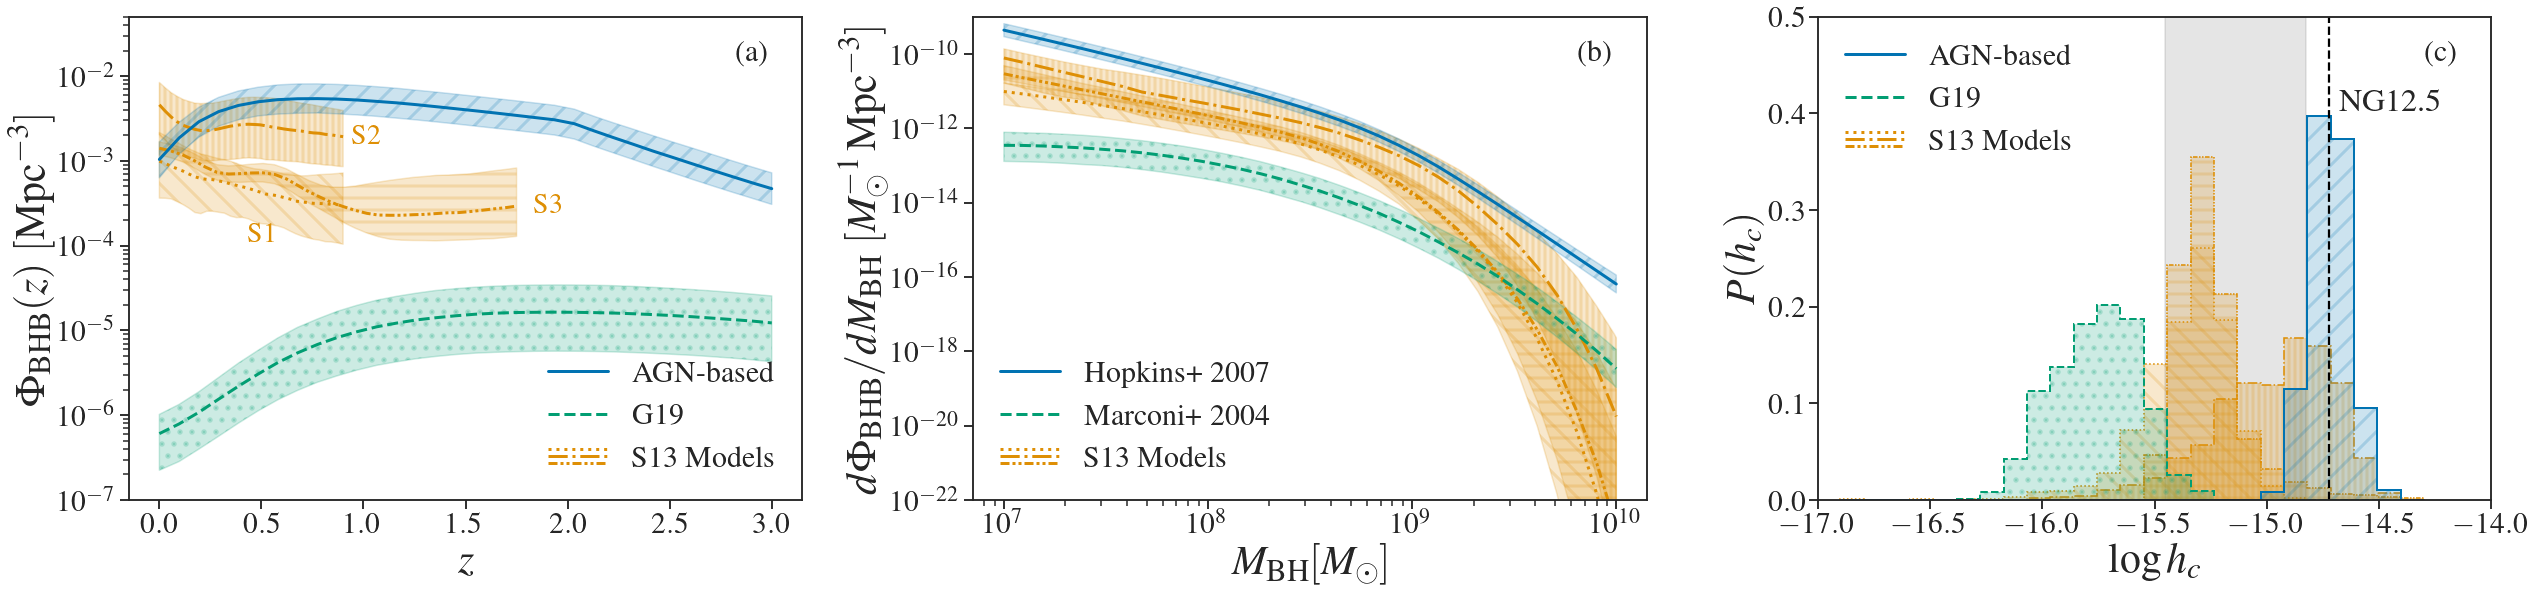

In [183]:
log_nz_i_l_kw_fid_min = np.floor(np.min(np.log10([np.min(differential_number_density_q[1]), np.min(S1_number_density_q[1]),
                                                  np.min(S2_number_density_q[1]), np.min(S3_number_density_q[1])])))
log_nz_i_l_kw_fid_max = np.ceil(np.max(np.log10([np.max(differential_number_density_q[1]), np.max(S1_number_density_q[1]),
                                                 np.max(S2_number_density_q[1]), np.max(S3_number_density_q[1])])))


log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                            S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                           S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(1, 3, figsize=(36, 9))

label_fsize = 42
legend_fsize = 30
text_fs = 28

ax[0].tick_params()
ax[1].tick_params()

ax[0].fill_between(z_range_borch, S1_number_density_q[0], S1_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0].plot(z_range_borch, S1_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
ax[0].text(z_range_borch[int(n_mesh / 2) - 1], .9 * S1_number_density_q[0, int(n_mesh / 2) - 1], 'S1', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range_drory, S2_number_density_q[0], S2_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = ax[0].plot(z_range_drory, S2_number_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
ax[0].text(1.05 * z_range_drory[n_mesh - 1], S2_number_density_q[1, n_mesh - 1], 'S2', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range_ilbert, S3_number_density_q[0], S3_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = ax[0].plot(z_range_ilbert, S3_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0].text(1.05 * z_range_ilbert[n_mesh - 1], S3_number_density_q[1, n_mesh - 1], 'S3', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range, G19_number_density_q[0], G19_number_density_q[2], color=cs[2], alpha=.2, hatch='.')
m2, = ax[0].plot(z_range, G19_number_density_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[0].fill_between(z_range, differential_number_density_q[0], differential_number_density_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0].plot(z_range, differential_number_density_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\Phi_{\rm{BHB}}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0].set_xlabel(r'$z$', fontsize=label_fsize)
# ax[0].set_ylim((10 ** (log_nz_i_l_kw_fid_min - 1), 10 ** (log_nz_i_l_kw_fid_max + 1)))
ax[0].set_ylim(top=5e-2, bottom=1e-7)

ax[0].legend([m1, m2, (s1, s2, s3)], ['AGN-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', frameon=False, fontsize=legend_fsize)

ax[0].text(.95, .95, '(a)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0].transAxes)

ax[1].fill_between(10 ** log_m_bh_range, S1_local_bhmf_q[0], S1_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='\\')
s1, = ax[1].plot(10 ** log_m_bh_range, S1_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=':')
ax[1].fill_between(10 ** log_m_bh_range, S2_local_bhmf_q[0], S2_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='||')
s2, = ax[1].plot(10 ** log_m_bh_range, S2_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle='-.')
ax[1].fill_between(10 ** log_m_bh_range, S3_local_bhmf_q[0], S3_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='-')
s3, = ax[1].plot(10 ** log_m_bh_range, S3_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

ax[1].fill_between(10 ** log_m_bh_range, G19_local_bhmf_q[0], G19_local_bhmf_q[2], color=cs[2], alpha=.2, hatch='.')
m2, = ax[1].plot(10 ** log_m_bh_range, G19_local_bhmf_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[1].fill_between(10 ** log_m_bh_range, local_bhmf_q[0], local_bhmf_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[1].plot(10 ** log_m_bh_range, local_bhmf_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1].set_ylim(bottom=1e-22, top=1e-9)
ax[1].legend([m1, m2, (s1, s2, s3)], ['Hopkins+ 2007', 'Marconi+ 2004', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', frameon=False, fontsize=legend_fsize)
ax[1].text(.95, .95, '(b)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[1].transAxes)

ax[2].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2, fill=True, alpha=.2, hatch='.')
ax[2].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2)

ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-based', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-based', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

# ax[2].annotate(r'S13',
#                xy=(log_sesana_min - .3, .49))
# ax[2].errorbar(log_hc_mid, 0.45,
#              xerr=[[log_hc_l],
#                    [log_hc_h]],
#              capsize=4, color=cs[0])
# ax[2].annotate(r'This Work',
#                xy=(log_hc_min - .75, .44))

ax[2].axvline(np.log10(1.9e-15), color='k', linestyle='--')
ax[2].annotate(r'NG12.5',
               xy=(np.log10(1.9e-15) + .03, .4), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=0)
ax[2].set_xlabel(r'$\log h_{c}$', fontsize=label_fsize)
ax[2].set_ylabel(r'$P(h_{c})$', fontsize=label_fsize)
ax[2].set_xlim(left=-17, right=-14)
ax[2].set_ylim(top=.5)
ax[2].legend([m1, m2, (s1, s2, s3)], ['AGN-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)
ax[2].text(.95, .95, '(c)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[2].transAxes)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.pdf')
plt.savefig('../reports/figures/model_comparison.png')
plt.show()